In [1]:
import sqlite3
import pyimgur
from matplotlib import use
import yfinance as yf
import ta
import requests
import pandas as pd
import numpy as np
import datetime,time,re
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from pandas.core.frame import DataFrame

dict_from_ETF_list = pd.read_excel("ETF_list.xlsx")
ETF_list = dict_from_ETF_list['Number']
print(ETF_list[85])
today = datetime.date.today()
end = today - datetime.timedelta(days=1)
start = end - datetime.timedelta(days=365*3.5)

00897


In [2]:
conn = sqlite3.connect('ETF_list.db')
cursor = conn.cursor()

In [5]:
conn.execute("""CREATE TABLE if not exists Strategy_data
       (Date date ,
       Number TEXT ,
       Close FLOAT,
       '+2SD' FLOAT,
       '+1SD' FLOAT,
       TL FLOAT,
       '-1SD' FLOAT,
       '-2SD' FLOAT,
       bbh FLOAT,
       bbm FLOAT,
       bbl FLOAT,
       K FLOAT,
       D FLOAT,
       primary key (Date, Number));""")
conn.commit()

In [3]:
def five_line(data):   
    timetrend = list(range(1, data.shape[0]+1))
    data['timetrend'] = timetrend
    data = data[['timetrend','Close']]
    data = data.dropna()
    reg = LinearRegression()
    x = data['timetrend'].to_frame()
    y = data['Close'].to_frame()
    reg.fit(x,y)
    
    a = reg.intercept_ #截距
    beta = reg.coef_ #斜率
    longtrend = a + beta*x
    res = np.array(list(data['Close'])) - np.array(list(longtrend['timetrend']))
    std = np.std(res,ddof=1)
    fiveline = pd.DataFrame()
    fiveline['+2SD'] = longtrend['timetrend'] + (2*std)
    fiveline['+1SD'] = longtrend['timetrend'] + (1*std)
    fiveline['TL'] = longtrend['timetrend']
    fiveline['-1SD'] = longtrend['timetrend'] - (1*std)
    fiveline['-2SD'] = longtrend['timetrend'] - (2*std) 
    use_fiveline = pd.merge(data, fiveline[['+2SD','+1SD','TL','-1SD','-2SD']], left_index=True, right_index=True, how='left')
    pick_fiveline = use_fiveline[['Close','+2SD','+1SD','TL','-1SD','-2SD']]
    return pick_fiveline

def BBands(data): #布林通道，非樂活通道
    data_bb = data.copy()
    indicator_bb = ta.volatility.BollingerBands(close = data_bb['Close'])#, window = 20, window_dev = 2)
    data_bb['bbh'] = indicator_bb.bollinger_hband()
    data_bb['bbm'] = indicator_bb.bollinger_mavg()
    data_bb['bbl'] = indicator_bb.bollinger_lband()
    data_bb = data_bb.dropna()
    use_BBands = pd.merge(data, data_bb[['bbh','bbm','bbl']], left_index=True, right_index=True, how='left')
    pick_BBands = use_BBands[['bbh','bbm','bbl']]
    return pick_BBands

def KD(data):
    data_KD = data.copy()
    data_KD['min'] = data_KD['Low'].rolling(9).min()
    data_KD['max'] = data_KD['High'].rolling(9).max()
    data_KD['RSV'] = 100*(data_KD['Close'] - data_KD['min'])/(data_KD['max'] - data_KD['min'])
    data_KD = data_KD.dropna()

    K_list = [50]
    for num,rsv in enumerate(list(data_KD['RSV'])):
        K_yestarday = K_list[num]
        K_today = 2/3 * K_yestarday + 1/3 * rsv
        K_list.append(K_today)
    data_KD['K'] = K_list[1:]

    D_list = [50]
    for num,K in enumerate(list(data_KD['K'])):
        D_yestarday = D_list[num]
        D_today = 2/3 * D_yestarday + 1/3 * K
        D_list.append(D_today)
    data_KD['D'] = D_list[1:]
    use_KD = pd.merge(data, data_KD[['K','D']], left_index=True, right_index=True, how='left')
    pick_KD = use_KD[['K','D']]
    return pick_KD

In [6]:
for i in ETF_list:
    print(i)
    df = yf.download(f"{i}.TW", start = str(start), end = str(end))
    f = five_line(df)
    b = BBands(df)
    k = KD(df)
    merge_df = pd.merge(b,k, left_index=True, right_index=True, how='left')
    merge2_df = pd.merge(f, merge_df, left_index=True, right_index=True, how='left')
    merge2_df = merge2_df.dropna()
    merge2_df['Number'] = f'{i}'
    merge2_df['Date'] = merge2_df.index.strftime("%Y-%m-%d")
    pick_df = merge2_df[['Date','Number','Close','+2SD','+1SD','TL','-1SD','-2SD','bbh','bbm','bbl','K','D']]
    #print(len(pick_df))

    for j in range(len(pick_df)):
        #pick_df[i][6] = pick_df[i][6].astype(str)
        #print(pick_df.iloc[j][6])
        cursor.execute("insert into Strategy_data(Date, Number, Close, '+2SD', '+1SD', TL, '-1SD', '-2SD', bbh, bbm, bbl, K, D) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", tuple(pick_df.iloc[j]))
        conn.commit()
        #(pick_df[0][0], pick_df[0][1], ,,,)



0050
[*********************100%***********************]  1 of 1 completed
0051
[*********************100%***********************]  1 of 1 completed
0052
[*********************100%***********************]  1 of 1 completed
0053
[*********************100%***********************]  1 of 1 completed
0054
[*********************100%***********************]  1 of 1 completed
0055
[*********************100%***********************]  1 of 1 completed
0056
[*********************100%***********************]  1 of 1 completed
0057
[*********************100%***********************]  1 of 1 completed
006203
[*********************100%***********************]  1 of 1 completed
006204
[*********************100%***********************]  1 of 1 completed
006208
[*********************100%***********************]  1 of 1 completed
00690
[*********************100%***********************]  1 of 1 completed
00692
[*********************100%***********************]  1 of 1 completed
00701
[*********************10

[*********************100%***********************]  1 of 1 completed
00664R
[*********************100%***********************]  1 of 1 completed
00665L
[*********************100%***********************]  1 of 1 completed
00666R
[*********************100%***********************]  1 of 1 completed
00675L
[*********************100%***********************]  1 of 1 completed
00676R
[*********************100%***********************]  1 of 1 completed
00669R
[*********************100%***********************]  1 of 1 completed
00680L
[*********************100%***********************]  1 of 1 completed
00681R
[*********************100%***********************]  1 of 1 completed
00670L
[*********************100%***********************]  1 of 1 completed
00671R
[*********************100%***********************]  1 of 1 completed
00685L
[*********************100%***********************]  1 of 1 completed
00686R
[*********************100%***********************]  1 of 1 completed
00688L
[***********

In [4]:
#刪除資料表
sql = "DROP TABLE Strategy_data"
cursor.execute(sql)


In [62]:
sql ="select * from Strategy_data where Number = '0052'"
cursor.execute(sql)
data = cursor.fetchall()
print(data)

[('2019-01-16', '0052', 48.27000045776367, 69.69258100392393, 57.34672642676147, 45.000871849599015, 32.65501727243656, 20.3091626952741, 49.27961323884089, 47.619999694824216, 45.960386150807544, 87.09716215882962, 74.3280935374074), ('2019-01-17', '0052', 48.54999923706055, 69.80799848907661, 57.46214391191415, 45.11628933475169, 32.770434757589236, 20.424580180426776, 49.28598935395589, 47.621999740600586, 45.95801012724528, 91.39810810588641, 80.01809839356707), ('2019-01-18', '0052', 48.619998931884766, 69.92341597422929, 57.57756139706682, 45.23170681990437, 32.88585224274191, 20.539997665579453, 49.30387461381436, 47.62749977111817, 45.951124928421976, 92.57760501698243, 84.20460060137219), ('2019-01-21', '0052', 49.25, 70.03883345938196, 57.692978882219506, 45.34712430505705, 33.001269727894595, 20.655415150732136, 49.44649234902983, 47.664499855041505, 45.88250736105318, 95.05173667798829, 87.82031262691089), ('2019-01-22', '0052', 49.0, 70.15425094453464, 57.80839636737218, 4

In [95]:
def linebot_draw_fivelinekd(msg):
    conn = sqlite3.connect('ETF_list.db')
    cursor = conn.cursor()
    sql =f"select * from Strategy_data where Number = '{msg}'"
    cursor.execute(sql)
    data = cursor.fetchall()

    date = []
    close = []
    k = []
    d = []
    for row in data:
        date.append(row[0])
        close.append(row[2])
        k.append(row[11])
        d.append(row[12])
        
    #print(date)
    #day = int(826/10)
    #print(day)
    ax = plt.subplots()
    x_values = [date[0],date[day],date[2*day],date[3*day],date[4*day],date[5*day]
               ,date[6*day]]
    plt.figure(facecolor = 'white', figsize = (15,5), dpi=100)
    plt.plot(date, close)
    plt.plot(date, k)
    plt.plot(date, d)
    #plt.grid(True, axis = 'y')
    plt.title("0051.TW", color = 'black', fontsize = 24) 
    plt.ylabel("Stock price")
    plt.xticks(date,rotation = 45)
    ax.set_xticklabels(x_values)
    plt.savefig('FivelineKD0051.png')
    plt.plot

    CLIENT_ID = "57cd6881c0b51ab"
    PATH = "FivelineKD0051.png"
    im = pyimgur.Imgur(CLIENT_ID)
    uploaded_image = im.upload_image(PATH, title="FivelineKD0051")
    return uploaded_image.link

['2019-01-16', '2019-01-17', '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29', '2019-01-30', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16', '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25', '2019-04-26', '2019-04-29', '2019-04-30', '2019-05-02', '2019-05-03', '2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10', '2019

AttributeError: 'tuple' object has no attribute 'set_xticklabels'

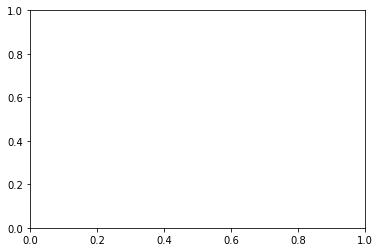

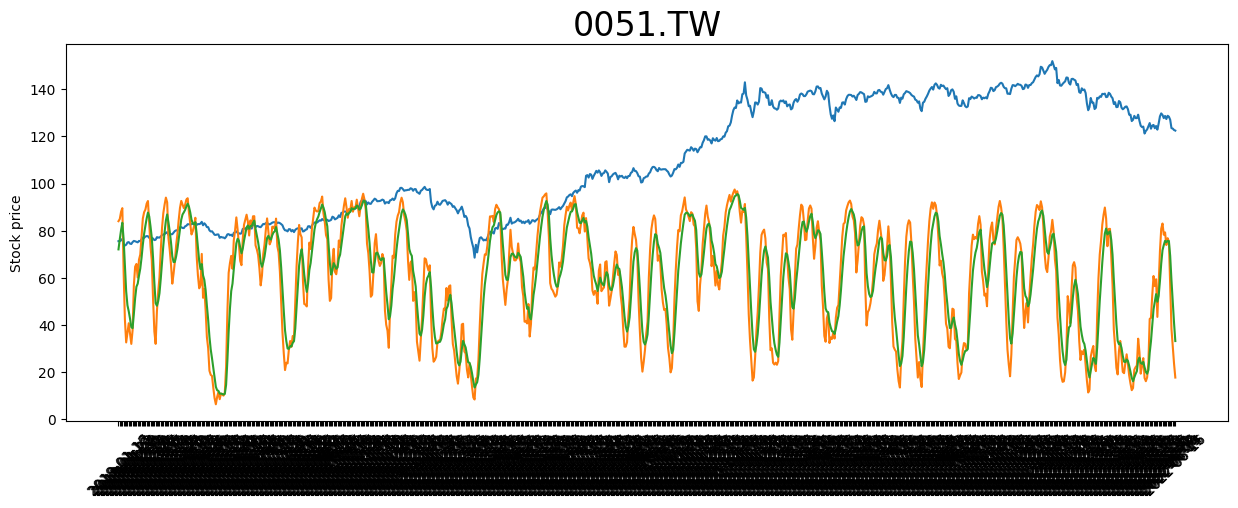

In [96]:
linebot_draw_fivelinekd('0050')